In [3]:
from langchain_openai import AzureChatOpenAI
import os
from dotenv import load_dotenv

load_dotenv()
azure_openai_api_key: str | None = os.getenv("AZURE_OPENAI_API_KEY")
if azure_openai_api_key:
    os.environ["AZURE_OPENAI_API_KEY"] = azure_openai_api_key

azure_openai_api_key

'2geV83WsZC2kxN9hPRAlVXBqSeiFW8f3sN1aYnQpztSNTPrj0o6IJQQJ99BBACYeBjFXJ3w3AAABACOGoM1S'

In [25]:
llm = AzureChatOpenAI(
    azure_deployment="gpt-4o", api_version="2024-08-01-preview", temperature=0
)

llm

AzureChatOpenAI(client=<openai.resources.chat.completions.Completions object at 0x7f5df7d48f20>, async_client=<openai.resources.chat.completions.AsyncCompletions object at 0x7f5df7c9e330>, root_client=<openai.lib.azure.AzureOpenAI object at 0x7f5df7fd5280>, root_async_client=<openai.lib.azure.AsyncAzureOpenAI object at 0x7f5df7c5ac00>, temperature=0.0, model_kwargs={}, openai_api_key=SecretStr('**********'), disabled_params={'parallel_tool_calls': None}, azure_endpoint='https://open-aj.openai.azure.com/', deployment_name='gpt-4o', openai_api_version='2024-08-01-preview', openai_api_type='azure')

In [5]:
result = llm.invoke("Hello, how are you?")
result

AIMessage(content="Hello! I'm just a bunch of code, so I don't have feelings, but I'm here and ready to help you with whatever you need. How about you? How are you doing? 😊", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 38, 'prompt_tokens': 13, 'total_tokens': 51, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-11-20', 'system_fingerprint': 'fp_b705f0c291', 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'jailbreak': {'filtered': False, 'detected': False}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': False, 'severity': 'safe'}}}], 'finish_reason': 'stop', 'logprobs': None, 'content_filter_results': {'

In [6]:
from typing_extensions import TypedDict


class LearningState(TypedDict):
    prompt: str

In [7]:
# prompt: create an example from above LearningState
india_state: LearningState = LearningState(prompt="hello from India")

In [11]:
print(india_state)
print(india_state["prompt"])
print(india_state["prompt"] + " I am")
print(india_state)
print(type(india_state))

{'prompt': 'hello from India'}
hello from India
hello from India I am
{'prompt': 'hello from India'}
<class 'dict'>


In [12]:
def node_1(state: LearningState) -> LearningState:
    print("---Node 1 State---", state)
    return LearningState(prompt=state["prompt"] + " I am")

In [13]:
def node_2(state: LearningState) -> LearningState:
    print("---Node 2 State---", state)
    return {"prompt": state["prompt"] + " happy!"}

In [15]:
from IPython.display import Image, display  # Preview Graph

from langgraph.graph import StateGraph, START, END
from langgraph.graph.state import CompiledStateGraph  # type

# Build graph
builder = StateGraph(state_schema=LearningState)
print(type(builder))

<class 'langgraph.graph.state.StateGraph'>


In [16]:
# Nodes
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)

In [17]:
# Simples Edges Logic
builder.add_edge(START, "node_1")
builder.add_edge("node_1", "node_2")
builder.add_edge("node_2", END)

In [19]:
# Add
graph: CompiledStateGraph = builder.compile()
print(graph)
print(graph.get_graph())

Graph(nodes={'__start__': Node(id='__start__', name='__start__', data=<class 'langchain_core.utils.pydantic.LangGraphInput'>, metadata=None), 'node_1': Node(id='node_1', name='node_1', data=node_1(tags=None, recurse=True, explode_args=False, func_accepts_config=False, func_accepts={}), metadata=None), 'node_2': Node(id='node_2', name='node_2', data=node_2(tags=None, recurse=True, explode_args=False, func_accepts_config=False, func_accepts={}), metadata=None), '__end__': Node(id='__end__', name='__end__', data=<class 'langchain_core.utils.pydantic.LangGraphOutput'>, metadata=None)}, edges=[Edge(source='__start__', target='node_1', data=None, conditional=False), Edge(source='node_1', target='node_2', data=None, conditional=False), Edge(source='node_2', target='__end__', data=None, conditional=False)])


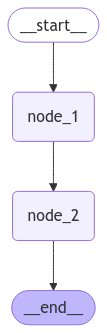

In [21]:
# view
display(Image(graph.get_graph().draw_mermaid_png()))

In [42]:
from typing_extensions import TypedDict
from langchain_core.messages.ai import AIMessage


class FirstLLMAgentCall(TypedDict):
    prompt: str
    output: str

In [43]:
def llm_node(state: FirstLLMAgentCall):
    print("---Node 1---", state)
    prompt = state["prompt"]
    ai_msg: AIMessage = llm.invoke(prompt)
    return {"output": ai_msg.content}

In [35]:
greet_message = llm_node(FirstLLMAgentCall(prompt="Hello from India"))
print(greet_message)

---Node 1--- {'prompt': 'Hello from India'}
{'output': "Hello from here! 😊 How are you doing today? How's everything in beautiful India?"}


In [44]:
from IPython.display import Image, display  # Preview Graph

from langgraph.graph import StateGraph, START, END
from langgraph.graph.state import CompiledStateGraph  # type

# Build graph
builder: StateGraph = StateGraph(state_schema=FirstLLMAgentCall)

# Define Nodes
builder.add_node("llm_call_node", llm_node)

# Add Edges
builder.add_edge(START, "llm_call_node")
builder.add_edge("llm_call_node", END)

# Compile Graph
graph: CompiledStateGraph = builder.compile()

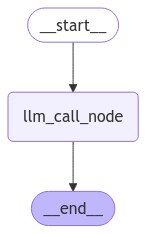

In [45]:
# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [46]:
result = graph.invoke({"prompt": "Motivate me to learn LangGraph"})

---Node 1--- {'prompt': 'Motivate me to learn LangGraph'}


In [47]:
print(result)

{'prompt': 'Motivate me to learn LangGraph', 'output': 'Absolutely! Learning **LangGraph** (assuming you\'re referring to a graph-based language model framework or a similar concept) can be an incredibly rewarding and forward-thinking skill to develop. Here\'s why you should dive in and get excited about it:\n\n---\n\n### 🚀 **1. Cutting-Edge Technology**\nLangGraph represents the intersection of **graph theory** and **language models**, two of the most exciting fields in AI and data science. By learning it, you\'re positioning yourself at the forefront of innovation, where the future of AI is being shaped. Imagine being part of the next big leap in natural language processing (NLP)!\n\n---\n\n### 🌐 **2. Real-World Applications**\nLangGraph can be applied to solve **complex, real-world problems**:\n- **Knowledge Graphs**: Build smarter systems that understand relationships between concepts (e.g., Google Knowledge Graph).\n- **Recommendation Systems**: Create personalized recommendations

In [48]:
# just another helpter function
import textwrap
from IPython.display import display, Markdown


def to_markdown(text) -> Markdown:
    text: str = text.replace("•", "  *")
    return Markdown(textwrap.indent(text, "> ", predicate=lambda _: True))

In [49]:
print("PROMPT: ", result["prompt"])
to_markdown(result["output"])

PROMPT:  Motivate me to learn LangGraph


> Absolutely! Learning **LangGraph** (assuming you're referring to a graph-based language model framework or a similar concept) can be an incredibly rewarding and forward-thinking skill to develop. Here's why you should dive in and get excited about it:
> 
> ---
> 
> ### 🚀 **1. Cutting-Edge Technology**
> LangGraph represents the intersection of **graph theory** and **language models**, two of the most exciting fields in AI and data science. By learning it, you're positioning yourself at the forefront of innovation, where the future of AI is being shaped. Imagine being part of the next big leap in natural language processing (NLP)!
> 
> ---
> 
> ### 🌐 **2. Real-World Applications**
> LangGraph can be applied to solve **complex, real-world problems**:
> - **Knowledge Graphs**: Build smarter systems that understand relationships between concepts (e.g., Google Knowledge Graph).
> - **Recommendation Systems**: Create personalized recommendations by analyzing user behavior and preferences.
> - **Semantic Search**: Enable more accurate and context-aware search engines.
> - **Social Network Analysis**: Understand and predict patterns in social media or organizational networks.
> 
> By mastering LangGraph, you'll have the tools to tackle these challenges and make a tangible impact.
> 
> ---
> 
> ### 🧠 **3. Supercharge Your Problem-Solving Skills**
> Graph-based approaches are **intuitive yet powerful**. They allow you to model relationships and dependencies in ways that traditional methods can't. Learning LangGraph will sharpen your ability to think in terms of **connections, hierarchies, and networks**, which is a valuable skill in any technical field.
> 
> ---
> 
> ### 💼 **4. Career Opportunities**
> The demand for professionals skilled in **graph-based AI** and **NLP** is skyrocketing. Companies like Google, Microsoft, and OpenAI are investing heavily in these technologies. By learning LangGraph, you'll make yourself a **highly sought-after expert** in a niche but rapidly growing area.
> 
> ---
> 
> ### 🛠️ **5. Build Cool Projects**
> LangGraph opens the door to creating **innovative and impactful projects**:
> - Build a chatbot that understands context better than ever.
> - Create a graph-based summarization tool for massive datasets.
> - Develop a system that maps out and visualizes relationships in unstructured text.
> 
> The possibilities are endless, and you'll have the satisfaction of building something truly unique.
> 
> ---
> 
> ### 🌱 **6. Learn Once, Apply Everywhere**
> The skills you gain from LangGraph are **transferable**:
> - **Graph Theory**: Useful in data science, network analysis, and even game development.
> - **NLP**: A core skill in AI, applicable to chatbots, translation, and more.
> - **Programming**: You'll likely deepen your knowledge of Python, libraries like NetworkX, and frameworks like PyTorch or TensorFlow.
> 
> By learning LangGraph, you're investing in a skill set that will serve you across multiple domains.
> 
> ---
> 
> ### 🔮 **7. Be a Pioneer**
> LangGraph is still a relatively new concept (or at least not as mainstream as other AI tools). By learning it now, you're becoming an **early adopter**. This gives you the chance to:
> - Contribute to the field.
> - Share your knowledge with others.
> - Stand out as a thought leader in your industry.
> 
> ---
> 
> ### 🧗 **8. Challenge Yourself**
> Learning something new is always a challenge, but that's what makes it exciting! LangGraph will push you to think differently, explore new paradigms, and grow as a developer, data scientist, or researcher. The sense of accomplishment you'll feel when you master it will be worth every moment of effort.
> 
> ---
> 
> ### 🔥 **9. Stay Ahead of the Curve**
> AI is evolving rapidly, and the ability to work with **graph-based models** could soon become a **must-have skill**. By starting now, you're future-proofing your career and staying ahead of the competition.
> 
> ---
> 
> ### 🌟 **10. It's Fun!**
> At its core, LangGraph is about exploring relationships and connections—something that's inherently fascinating. Whether you're visualizing a network of ideas or building a system that "thinks" in graphs, you'll find the process both intellectually stimulating and creatively fulfilling.
> 
> ---
> 
> ### Final Thought:
> LangGraph isn't just a tool—it's a **gateway to the future of AI**. By learning it, you're not just keeping up with the times; you're helping to shape them. So take the leap, embrace the challenge, and start your journey into the exciting world of LangGraph today. You've got this! 💪
> 
